# Overview
This notebook will construct the quart-five problem, then insert a (real) fracture in the middle.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [2]:
# Create grid
Nx=Ny=40
phys_dims=[1,1]

fracture = np.array([[0.2, 0.8], [0.5, 0.5]])
gb = pp.meshing.cart_grid([fracture], [Nx, Ny], physdims=phys_dims)

data_key="flow"

In [3]:
# Matrix bdy condition
inflow=1
outflux=-1

# Thickness of fracture
aperture = 1e-3
fracture_perm = 1e5

for g, d in gb:
    # The concept of specific volumes accounts for the thickness
    # of the fracture, which is collapsed in the mixed-dimensional
    # model.
    specific_volumes = np.power(aperture, gb.dim_max()-g.dim)
    # Permeability
    k = np.ones(g.num_cells) * specific_volumes
    if g.dim < gb.dim_max():
        k *= fracture_perm
    perm = pp.SecondOrderTensor(k)                     

    # Unitary scalar source already integrated in each cell
    #f = 1e-2* g.cell_volumes * specific_volumes 
    f = np.zeros(g.num_cells)

    # Boundary conditions
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    bc_val = np.zeros(g.num_faces)
    
    # Assign boundary conditions to matrix
    if g.dim == gb.dim_max():
        
        labels = np.array(['neu']*b_faces.size)
        
        # Coordinates and index of face centers
        coord_faces = np.vstack((g.face_centers[0, b_faces], g.face_centers[1, b_faces], np.array(range(b_faces.size))))

        # Find west face closest to (0,0)
        left_face = coord_faces[:,coord_faces[0]==0]
        ind_min_west = int(left_face[2,np.argmin(left_face[1])])
        labels[ind_min_west] = 'dir'

        # Find south face closest to (0,0)
        bot_face = coord_faces[:,coord_faces[1]==0]
        ind_min_south = int(bot_face[2,np.argmin(bot_face[0])])
        labels[ind_min_south] = 'dir'
        
        # Create BoundaryCondition object
        bc = pp.BoundaryCondition(g, b_faces, labels)

        # Adjust Dirichlet value
        bc_val[[ind_min_west, ind_min_south]] = inflow
        
        # Production well upper-right corner
        f[-1] = outflux
    else:
        bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
        

    parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    pp.initialize_data(g, d, data_key, parameters)

for e, d in gb.edges():
        gl, _ = gb.nodes_of_edge(e)
        mg = d["mortar_grid"]
        # Division through aperture/2 may be thought of as taking the gradient, i.e.
        # dividing by the distance from the matrix to the center of the fracture.
        kn = fracture_perm / (aperture/2)
        pp.initialize_data(mg, d, data_key, {"normal_diffusivity": kn})

In [4]:
flow_discretization = pp.Tpfa(data_key)
source_discretization = pp.ScalarSource(data_key)
for g, d in gb:
        d[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1}}
        d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization,
                                             "source": source_discretization}}
        
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)        
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
    d[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            g1: ("pressure", "diffusive"),
            g2: ("pressure", "diffusive"),
            e: ("mortar_flux", flow_coupling_discretization),
        }
    }

In [5]:
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
solution = sps.linalg.spsolve(A, b)
assembler.distribute_variable(solution)

In [9]:
g = gb.grids_of_dimension(2)[0]
data = gb.node_props(g)
data

{'node_number': 0,
 'discretization_matrices': {'flow': {'flux': <3304x1600 sparse matrix of type '<class 'numpy.float64'>'
   	with 6400 stored elements in Compressed Sparse Column format>,
   'bound_flux': <3304x3304 sparse matrix of type '<class 'numpy.float64'>'
   	with 208 stored elements in Compressed Sparse Column format>,
   'bound_pressure_cell': <3304x1600 sparse matrix of type '<class 'numpy.float64'>'
   	with 6400 stored elements in COOrdinate format>,
   'bound_pressure_face': <3304x3304 sparse matrix of type '<class 'numpy.float64'>'
   	with 3304 stored elements (1 diagonals) in DIAgonal format>,
   'source': <1600x1600 sparse matrix of type '<class 'numpy.float64'>'
   	with 0 stored elements in Compressed Sparse Column format>,
   'bound_source': <1600x1600 sparse matrix of type '<class 'numpy.float64'>'
   	with 1600 stored elements in Compressed Sparse Column format>}},
 'parameters': Data object for physical processes flow
 The keyword "flow" has the following par

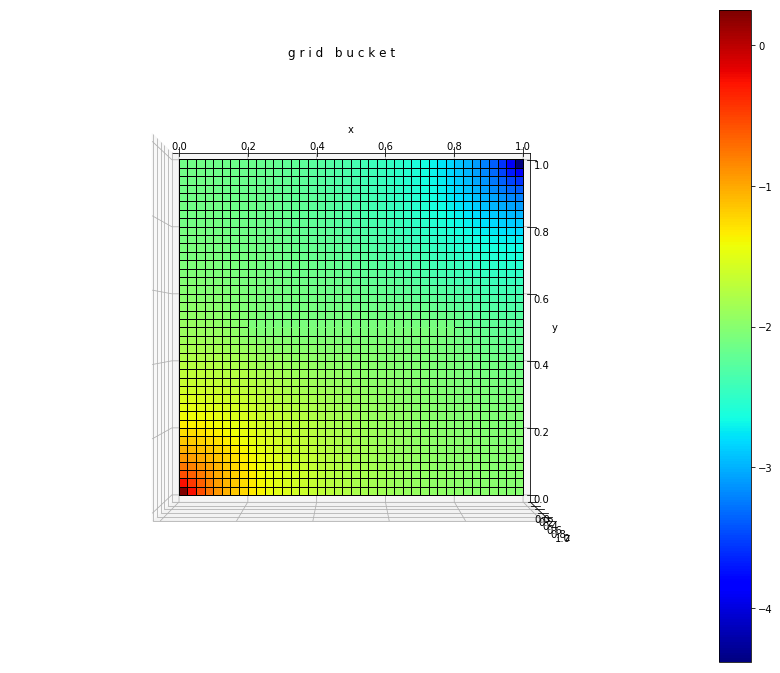

In [6]:
pp.plot_grid(gb, "pressure",figsize=(15, 12))